In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

SEED = 5678
np.random.seed(SEED)

In [3]:
train = pd.read_csv(r'C:\Users\Me\Kaggle\Titanic_revisited\data\train.csv')
test = pd.read_csv(r'C:\Users\Me\Kaggle\Titanic_revisited\data\test.csv')
print(train.shape, test.shape)

(891, 12) (418, 11)


# SOLS Classifier
> This is a custom classifier created using Scikit Learn's project template for custom estimators.
> It uses statsmodels OLS for the initial fit. Predict then uses the same OLS model to make a 
> prediction. The median of the predictions is subtracted from the prediction to create an estimated 
> residual. The estimated residual is then divided by the standard deviation of the residuals from the fit
> to create an estimated studentized residual. These studentized residuals are then tested against the
> hyperparameter "threshold" to determine the label. All  values greater than or equal to the threshold are 
> labeled True, and values less than the threshold are labeled False.

In [4]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
import pandas as pd
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.regression.linear_model import OLS

class SOLSClassifier(BaseEstimator, ClassifierMixin ):
    
    def __init__(self, threshold = 'threshold', est_method = 'est_method'):
        
        #decision threshold of studentized residuals
        self.threshold = threshold 
        self.est_method = est_method
        np.random.seed(SEED)
        
    def fit(self, X, y):
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y) 
        
        #convert to df
        self.X_ = pd.DataFrame(X)
        self.y_ = pd.DataFrame(y)         
        
        #Fit OLS model
        self.ols_mod = OLS(endog = self.y_, exog = self.X_)
        self.ols_result = self.ols_mod.fit()
        
        # Return the classifier
        return self

    def predict(self, X):
        
        # Check if fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # Input validation
        X = check_array(X)
        X_n = pd.DataFrame(X)
        
        #OLS prediction       
        prediction = self.ols_result.predict(X_n)        
        
        #calculate outlier and influence measures for OLS result
        inf = OLSInfluence(self.ols_result)
        
        #Staandard Deviation of studentized residuals
        std = inf.resid_std
        
        """
        Subtract the median of the predictions from the predictions to create an estimated residual.
        Then divide the estiamted residual by the by the estimated standard deviation, the
        standard deviation of the residuals from training, to create an estimated studentized residual.
           
        """ 
        # estimated residual
        estimated_residual = prediction - np.nanmedian(prediction)
        
        #estiamted studentized residual
        if self.est_method == 'mean':
            stud_res = estimated_residual/np.nanmean(std)    #estimate using mean
        if self.est_method == 'median':
            stud_res = prediction/np.nanmedian(std)         #estimate using median
        
        #create predictions based on the threshold
        self.preds = []        
        for res in stud_res:
            if res >= self.threshold:    
                #self.preds.append(True)
                self.preds.append(1)
            else:
                #self.preds.append(False)
                self.preds.append(0)
                
        return self.preds

# Functions

In [5]:
PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

#Get classifier metrics, based on DAND
def test_classifier(clf, dataset, feature_list, folds = 20):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    #data = np.array(dataset)
    labels, features = targetFeatureSplit(data)
    sss = StratifiedShuffleSplit(n_splits = folds, random_state = SEED)
    cv = sss.split(features, labels)
    
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print ("Warning: Found a predicted label not == 0 or 1.")
                print ("All predictions should take value 0 or 1.")
                print ("Evaluating performance for processed predictions:")
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print (clf)
        print (PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5))
        print (RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives))
        print ("")
    except:
        print ("Got a divide by zero when trying out:", clf)
        print ("Precision or recall may be undefined due to a lack of true positive predicitons.")


#convert dictionary to numpy array of features, from DAND       
def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    
    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print ("error: key ", feature, " not present")
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)

# prepares data for tester returns list and dict 
def tester_prep(dfn):
    features_list = dfn.columns.values
    data_dict = dfn.to_dict('index')
    return features_list, data_dict

#split FIRST row as labels, from DAND
def targetFeatureSplit( data ):
    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )
    return target, features

# Old Code
> Some of this code is from a submission made over two years ago and I don't recall what is borrowed and what is original. If you see your code in this section, thank you.

In [6]:
#Improved Age Interpolation based on Pclass, Parch, Sibsp
index_NaN_age = list(train["Age"][train["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = train["Age"].median()
    age_pred = train["Age"][((train['SibSp'] == train.iloc[i]["SibSp"]) & (train['Parch'] == train.iloc[i]["Parch"]) & (train['Pclass'] == train.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        train['Age'].iloc[i] = age_pred
    else :
        train['Age'].iloc[i] = age_med
        
# Filling missing value of Age in test
index_NaN_age = list(test["Age"][test["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = test["Age"].median()
    age_pred = test["Age"][((test['SibSp'] == test.iloc[i]["SibSp"]) & (test['Parch'] == test.iloc[i]["Parch"]) & (test['Pclass'] == test.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        test['Age'].iloc[i] = age_pred
    else :
        test['Age'].iloc[i] = age_med

#Add title variable
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in train["Name"]]
train["Title"] = pd.Series(dataset_title)
train["Title"].head()

dataset_title = [i.split(",")[1].split(".")[0].strip() for i in test["Name"]]
test["Title"] = pd.Series(dataset_title)
test["Title"].head()

# Convert to categorical values Title train
train["Title"] = train["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train["Title"] = train["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
train["Title"] = train["Title"].astype(int)

# Convert to categorical values Title test
test["Title"] = test["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test["Title"] = test["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
test["Title"] = test["Title"].astype(int)

# Drop Name variable
train.drop(labels = ["Name"], axis = 1, inplace = True)
test.drop(labels = ["Name"], axis = 1, inplace = True)

# Create a family size descriptor from SibSp and Parch

train["Fsize"] = train["SibSp"] + train["Parch"] + 1
# Create new feature of family size
train['Single'] = train['Fsize'].map(lambda s: 1 if s == 1 else 0)
train['SmallF'] = train['Fsize'].map(lambda s: 1 if s == 2  else 0)
train['MedF']   = train['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
train['LargeF'] = train['Fsize'].map(lambda s: 1 if s >= 5 else 0)

test["Fsize"] = test["SibSp"] + test["Parch"] + 1
test['Single'] = test['Fsize'].map(lambda s: 1 if s == 1 else 0)
test['SmallF'] = test['Fsize'].map(lambda s: 1 if s == 2  else 0)
test['MedF']   = test['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
test['LargeF'] = test['Fsize'].map(lambda s: 1 if s >= 5 else 0)


# Create the column Child and assign to 'NaN'
train["Child"] = float('NaN')
test["Child"] = float('NaN')

# Assign 1 to passengers < 20, 0 to those >= 20*******************************
age_var = 9
train["Child"][train["Age"] < age_var] = 1
train["Child"][train["Age"] >= age_var] = 0

test["Child"][test["Age"] < age_var] = 1
test["Child"][test["Age"] >= age_var] = 0

# Convert male and female groups to integer form
train["Sex"][train["Sex"] == "male"] = 0
train["Sex"][train["Sex"] == "female"] = 1
test["Sex"][test["Sex"] == "male"] = 0
test["Sex"][test["Sex"] == "female"] = 1

# Impute the Embarked variable
train["Embarked"] = train["Embarked"].fillna("S")
# Embarked to int
train["Embarked"][train["Embarked"] == "S"] = 0
train["Embarked"][train["Embarked"] == "C"] = 1
train["Embarked"][train["Embarked"] == "Q"] = 2
test["Embarked"][test["Embarked"] == "S"] = 0
test["Embarked"][test["Embarked"] == "C"] = 1
test["Embarked"][test["Embarked"] == "Q"] = 2

test.Fare[152] = test.Fare.median()

In [7]:

for f in train.columns: 
    if train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(train[f].values)) 
        train[f] = lbl.transform(list(train[f].values))
        
for f in test.columns: 
    if test[f].dtype=='object': 
       lbl = preprocessing.LabelEncoder() 
       lbl.fit(list(test[f].values)) 
       test[f] = lbl.transform(list(test[f].values))

In [8]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF,Child
0,1,0,3,0,22.0,1,0,523,7.2500,147,0,2,2,0,1,0,0,0.0
1,2,1,1,1,38.0,1,0,596,71.2833,81,1,1,2,0,1,0,0,0.0
2,3,1,3,1,26.0,0,0,669,7.9250,147,0,1,1,1,0,0,0,0.0
3,4,1,1,1,35.0,1,0,49,53.1000,55,0,1,2,0,1,0,0,0.0
4,5,0,3,0,35.0,0,0,472,8.0500,147,0,2,1,1,0,0,0,0.0


In [9]:
#make survived the first column for tester
train = train.reindex(columns=(['Survived'] + list([a for a in train.columns if a != 'Survived']) ))
train.head()

,Survived,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF,Child
0,0,1,3,0,22.0,1,0,523,7.2500,147,0,2,2,0,1,0,0,0.0
1,1,2,1,1,38.0,1,0,596,71.2833,81,1,1,2,0,1,0,0,0.0
2,1,3,3,1,26.0,0,0,669,7.9250,147,0,1,1,1,0,0,0,0.0
3,1,4,1,1,35.0,1,0,49,53.1000,55,0,1,2,0,1,0,0,0.0
4,0,5,3,0,35.0,0,0,472,8.0500,147,0,2,1,1,0,0,0,0.0


# Models

In [10]:
 # ols pipe smt
k = 19
ols_m = SOLSClassifier(0.745, est_method = 'mean')  #82933 0.747, mean    
#model = Pipeline([('fpr', SelectFpr()),  ('ols', ols_m)]) 
#model = Pipeline([  ('kBest', SelectKBest( k = k)), ('ols', ols_m)])
#model = Pipeline([ ('smt', smt),  ('ols', ols_m)])
model = ols_m
feat, dat = tester_prep(train)
test_classifier(model, dat, feat, folds = 50)


SOLSClassifier(est_method='mean', threshold=0.745)
	Accuracy: 0.82933	Precision: 0.81354	Recall: 0.72800	F1: 0.76840	F2: 0.74364
	Total predictions: 4500	True positives: 1274	False positives:  292	False negatives:  476	True negatives: 2458



In [11]:
X = train.copy()
y = train['Survived'].copy()
X.drop(['Survived'], axis = 1, inplace = True)
print(y.shape, X.shape)

(891,) (891, 17)


In [12]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [13]:
X.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF,Child
0,1,3,0,22.0,1,0,523,7.2500,147,0,2,2,0,1,0,0,0.0
1,2,1,1,38.0,1,0,596,71.2833,81,1,1,2,0,1,0,0,0.0
2,3,3,1,26.0,0,0,669,7.9250,147,0,1,1,1,0,0,0,0.0
3,4,1,1,35.0,1,0,49,53.1000,55,0,1,2,0,1,0,0,0.0
4,5,3,0,35.0,0,0,472,8.0500,147,0,2,1,1,0,0,0,0.0


In [14]:
kfold = StratifiedKFold(n_splits=10)

#Scoring Function**********************************************************************************
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 10, scoring=scoring)
    return np.mean(xval)

In [15]:
clf = SOLSClassifier(0.747, est_method = 'mean')

In [16]:
res = compute_score(clf, X, y, scoring='accuracy')
res

0.8282771535580524

QDA: 0.644216 (0.020654)
KNN: 0.601550 (0.052605)
DTC: 0.763405 (0.097404)
GNB: 0.794671 (0.034670)
SVM: 0.667849 (0.040306)
ABC: 0.729647 (0.095237)
MLP: 0.764396 (0.047492)
RID: 0.832760 (0.022385)
log: 0.815944 (0.020775)
SOLS: 0.830532 (0.016388)


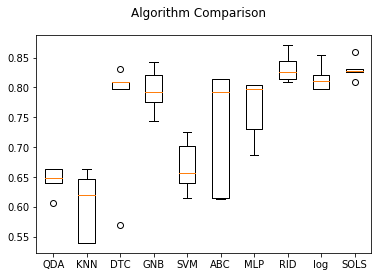

In [17]:
#adapted from https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
models = []
models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('GPC', GaussianProcessClassifier(1.0 * RBF(1.0),random_state = SEED)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state = SEED)))
models.append(('GNB', GaussianNB()))
models.append(('SVM', SVC(random_state = SEED)))
models.append(('ABC', AdaBoostClassifier(random_state = SEED)))
models.append(('MLP', MLPClassifier( random_state = SEED, max_iter=1000)))
models.append(('RID', RidgeClassifier(random_state = SEED)))
models.append(('log', LogisticRegression(random_state = SEED)))
models.append(('SOLS', SOLSClassifier(0.745, est_method = 'mean')))

# test and plot all models in models list
def test_models(models, data, target):
    results = []
    names = []
    scoring = 'accuracy'

    for name, model in models:
        kfold = StratifiedKFold(n_splits=5, random_state=SEED)
        cv_results = cross_val_score(model, data, target, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        #classification_metrics(y_val, rfc_pred)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()


#run test    
test_models(models, X, y)

# Final Data

In [18]:
sols_mod = SOLSClassifier(0.745, est_method = 'mean')
sols_mod.fit(X, y)
final_submit = sols_mod.predict(test)

In [19]:
from collections import Counter
Counter(final_submit)

Counter({0: 268, 1: 150})

In [20]:
#Final array*************************************************************************************
PassengerId =np.array(test["PassengerId"]).astype(int)
my_solution = pd.DataFrame(final_submit, PassengerId, columns = ["Survived"])

my_solution.to_csv("solution_SOLSClass_oldData_1.csv", index_label = ["PassengerId"])

# Score
>0.77990 Previous best Score of 0.80861 with ExtraTrees on old data